In [113]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from moexalgo import Market, Ticker

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import copy

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor

from datetime import datetime

In [2]:
def get_result_model_training(real, pred, visualization=False):   
    rmse = round(mean_squared_error(real, pred, squared=False), 5)
    r2 = round(r2_score(real, pred), 5)
    mae = round(mean_absolute_error(real, pred), 5)
    mape = round(mean_absolute_percentage_error(real, pred), 5)

    print(f'MAE: {mae}\nR2: {r2}\nRMSE: {rmse}\nMAPE: {mape* 100} %\n')
    
    print(f'\nМедианное значение {round(real.median(), 5)}\nСредние значение {round(real.mean(), 5)}\n')

    if visualization:
        fig, ax = plt.subplots(1, 2, figsize=(18, 7))
        
        sns.scatterplot(x=pred, y=real, ax=ax[0])
        ax[0].plot((real.min(), real.max()), (real.min(), real.max()), color='red')
        ax[0].set_title('График рассеяния на модели', fontsize=20)
        ax[0].set_xlabel('Прогноз', fontsize=15)
        ax[0].set_ylabel('Реальное значение', fontsize=15)

        sns.histplot(data=real - pred, kde=True, ax=ax[1])
        ax[1].set_title('Распределение ошибок', fontsize=20)
        ax[1].set_xlabel('Реальное значение минус прогнозное', fontsize=15)
        ax[1].set_ylabel('')

        plt.show()

# Выгрузка данных

In [10]:
stocks = ['AFLT', 'BANE', 'DSKY', 'FEES', 'GAZP', 'PHOR', 'POSI', 'SBER', 'YNDX', 'MTLR']

for year in ['2020', '2021', '2022', '2023']:
    tradestats = pd.read_csv(f'./data/tradestats_{year}.csv', sep=';')
    orderstats = pd.read_csv(f'./data/orderstats_{year}.csv', sep=';')
    obstats = pd.read_csv(f'./data/obstats_{year}.csv', sep=';')

    tradestats_cur_stock = tradestats[tradestats.secid.isin(stocks)]
    orderstats_cur_stock = orderstats[orderstats.secid.isin(stocks)]
    obstats_cur_stock = obstats[obstats.secid.isin(stocks)]

    del tradestats, orderstats, obstats
    
    tradestats_cur_stock.drop(columns=['SYSTIME'], inplace=True)
    orderstats_cur_stock.drop(columns=['SYSTIME'], inplace=True)
    obstats_cur_stock.drop(columns=['val_b', 'val_s', 'vol_b', 'vol_s', 'SYSTIME'], inplace=True)

    if year == '2020':
        df = tradestats_cur_stock.merge(orderstats_cur_stock, on=['secid', 'tradedate', 'tradetime'], how='left')
        df = df.merge(obstats_cur_stock, on=['secid', 'tradedate', 'tradetime'], how='left')
    else:
        cur_df = tradestats_cur_stock.merge(orderstats_cur_stock, on=['secid', 'tradedate', 'tradetime'], how='left')
        cur_df = cur_df.merge(obstats_cur_stock, on=['secid', 'tradedate', 'tradetime'], how='left')
        
        df = pd.concat([df, cur_df])
        
        del cur_df
    
    del tradestats_cur_stock, orderstats_cur_stock, obstats_cur_stock

In [12]:
# дроп индекс
df['tradetime'] = df['tradetime'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
df['tradedate'] = df['tradedate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

df.fillna(-1, inplace=True)

In [161]:
# df_copy = df.copy()
df = df_copy[df_copy.secid == 'AFLT']
df.reset_index(drop=True, inplace=True)

# df = df_copy

# Добавление новых признаков 

In [162]:
# минимумы и макимумы за прошлый час 
df['max_prev_hour'] = df['pr_close'].rolling(window=12+1).max()
df['min_prev_hour'] = df['pr_close'].rolling(window=12+1).min()

# минимумы и макимумы за прошлый день 
df['max_prev_day'] = df['pr_close'].rolling(window=104+1).max()
df['min_prev_day'] = df['pr_close'].rolling(window=104+1).min()

# минимумы и макимумы за прошлую неделю 
df['max_prev_weak'] = df['pr_close'].rolling(window=104*5+1).max()
df['min_prev_weak'] = df['pr_close'].rolling(window=104*5+1).min()

# минимумы и макимумы за второй прошлый час
df['max_prev_2_hour'] = df['pr_close'].rolling(window=12*2+1).max()
df['min_prev_2_hour'] = df['pr_close'].rolling(window=12*2+1).min()

# минимумы и макимумы за второй прошлый день 
df['max_prev_2_day'] = df['pr_close'].rolling(window=104*2+1).max()
df['min_prev_2_day'] = df['pr_close'].rolling(window=104*2+1).min()

# минимумы и макимумы за вторую прошлую неделию
df['max_prev_2_weak'] = df['pr_close'].rolling(window=104*5*2+1).max() 
df['min_prev_2_weak'] = df['pr_close'].rolling(window=104*5*2+1).min()  

# минимумы и макимумы за третий прошлый час
df['max_prev_3_hour'] = df['pr_close'].rolling(window=12*3+1).max() 
df['min_prev_3_hour'] = df['pr_close'].rolling(window=12*3+1).min()

# минимумы и макимумы за третий прошлый день 
df['max_prev_3_day'] = df['pr_close'].rolling(window=104*3+1).max()
df['min_prev_3_day'] = df['pr_close'].rolling(window=104*3+1).min()

# минимумы и макимумы за третию прошлую неделию
df['max_prev_3_weak'] = df['pr_close'].rolling(window=104*5*31).max()
df['min_prev_3_weak'] = df['pr_close'].rolling(window=104*5*31).min()

In [163]:
# предыдущие цена закрытия за час, день, неделю, (месяц)
df['prev_pr_close'] = df.pr_close.shift(1)
df['prev_pr_close_2'] = df.pr_close.shift(2)
df['prev_pr_close_3'] = df.pr_close.shift(3)
df['prev_pr_close_hour'] = df.pr_close.shift(12)
df['prev_pr_close_hour'] = df.pr_close.shift(12*2)
df['prev_pr_close_hour'] = df.pr_close.shift(12*3)
df['prev_pr_close_day'] = df.pr_close.shift(104)
df['prev_pr_close_weak'] = df.pr_close.shift(104*5)

In [164]:
# разность между ценой открытия и закрытия за прошлый час, день, месяц

df['prev_pr_diff_hour'] = df.pr_close.shift(1) - df.pr_open.shift(12)

df['prev_pr_diff_1'] = df.pr_close.shift(1) - df.pr_open.shift(1)
df['prev_pr_diff_2'] = df.pr_close.shift(1) - df.pr_open.shift(2)
df['prev_pr_diff_3'] = df.pr_close.shift(1) - df.pr_open.shift(3)

In [165]:
# временные признаки
# дней до выходных
# 5 минутных свечей до закрытия торгов
df["day_of_week"] = df['tradedate'].apply(lambda x: x.weekday())
df["day_of_year"] = df['tradedate'].apply(lambda x: x.timetuple().tm_yday)
df["month"] = df['tradedate'].apply(lambda x: x.month)
df["week"] = df['tradedate'].apply(lambda x: x.isocalendar().week)
df["day"] = df['tradedate'].apply(lambda x: x.day)
df["hour"] = df['tradetime'].apply(lambda x: x.hour)
df["minute"] = df['tradetime'].apply(lambda x: x.minute)

df['candels_befor_day_end'] =  104 - ((df['hour'] - 10) * 12 + (df['minute']/ 5))   
df['days_before_hollydays'] =  5 - df['day_of_week']

In [142]:
df.fillna(-1, inplace=True)

In [143]:
to_drop = ['cancel_val_b', 'cancel_val_s', 'cancel_vol_b', 'cancel_vol_s', 'cancel_vwap_b', 'cancel_vwap_s', 
           'cancel_vol', 'cancel_val', 'cancel_orders', 'secid']
df.drop(columns=to_drop, inplace=True)

# Добавление целевой и разбиение на трейн и тест

In [97]:
# pd.set_option('display.max_rows', 150)

In [150]:
df['target_hour'] = df.pr_close.shift(-104*5)
# df['target_day'] = df.pr_close.shift(-104)
# df['target_weak'] = df.pr_close.shift(-104*5)

df = df[104*5*3:len(df)-104*5]

In [151]:
date_split = datetime.strptime('01-05-2023', "%d-%m-%Y").date()

train = df[df["tradedate"] < date_split].drop(columns=['tradedate', 'tradetime'])
X_train = train.drop(columns=['target_hour'])
y_train = train['target_hour']

test = df[df["tradedate"] >= date_split].drop(columns=['tradedate', 'tradetime'])
X_test = test.drop(columns=['target_hour'])
y_test = test['target_hour']

# Обучение

In [152]:
cbr = CatBoostRegressor(random_state=42, loss_function='MAE', verbose=False)
cbr.fit(X_train, y_train)

pred_cbr = cbr.predict(X_test)

In [ ]:
# MAE: 1.06269
# R2: 0.94055
# RMSE: 1.36796
# MAPE: 0.407 %

# MAE: 2.50339
# R2: 0.70809
# RMSE: 3.1583
# MAPE: 0.957 %

# MAE: 5.77841
# R2: -0.19062
# RMSE: 6.95948
# MAPE: 2.212 %

In [ ]:
# MAE: 4.92169
# R2: 0.76708
# RMSE: 5.89917
# MAPE: 1.9120000000000001

MAE: 1.76546
R2: 0.08004
RMSE: 2.03123
MAPE: 4.186 %


Медианное значение 41.65
Средние значение 41.96264



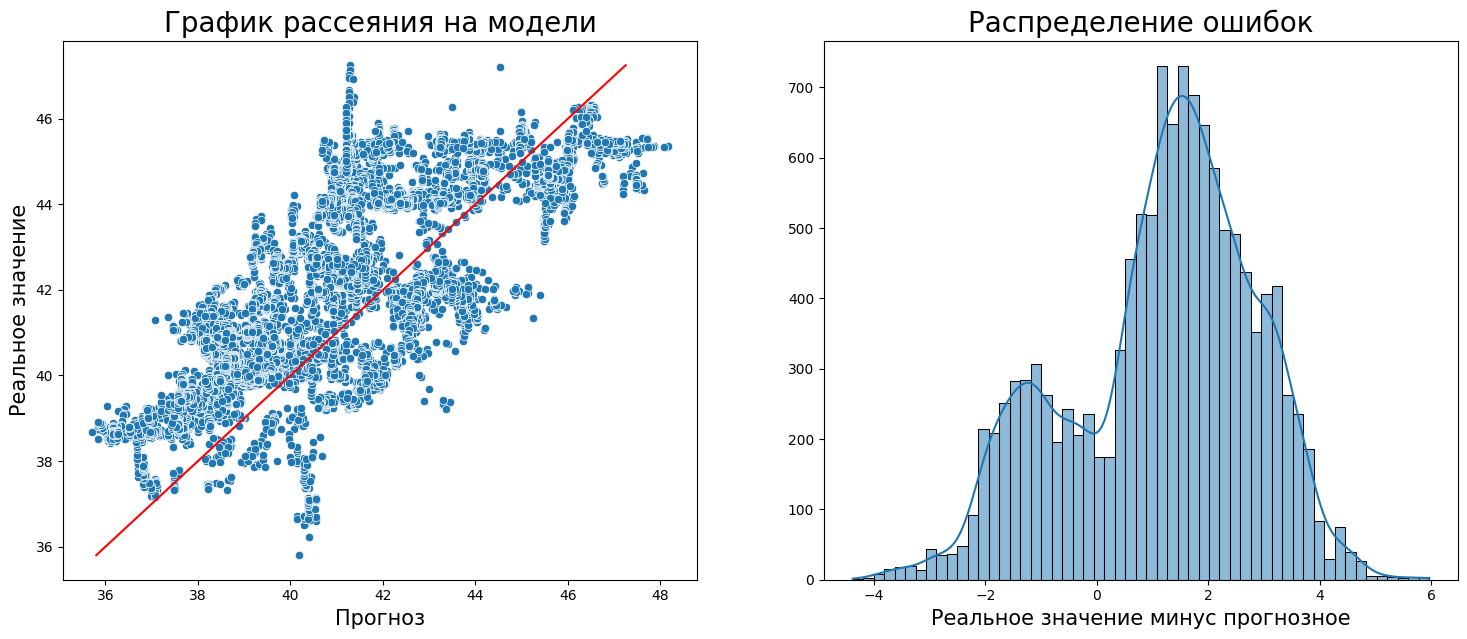

In [153]:
get_result_model_training(y_test, pred_cbr, visualization=True)

Text(0.5, 1.0, 'Feature Importance')

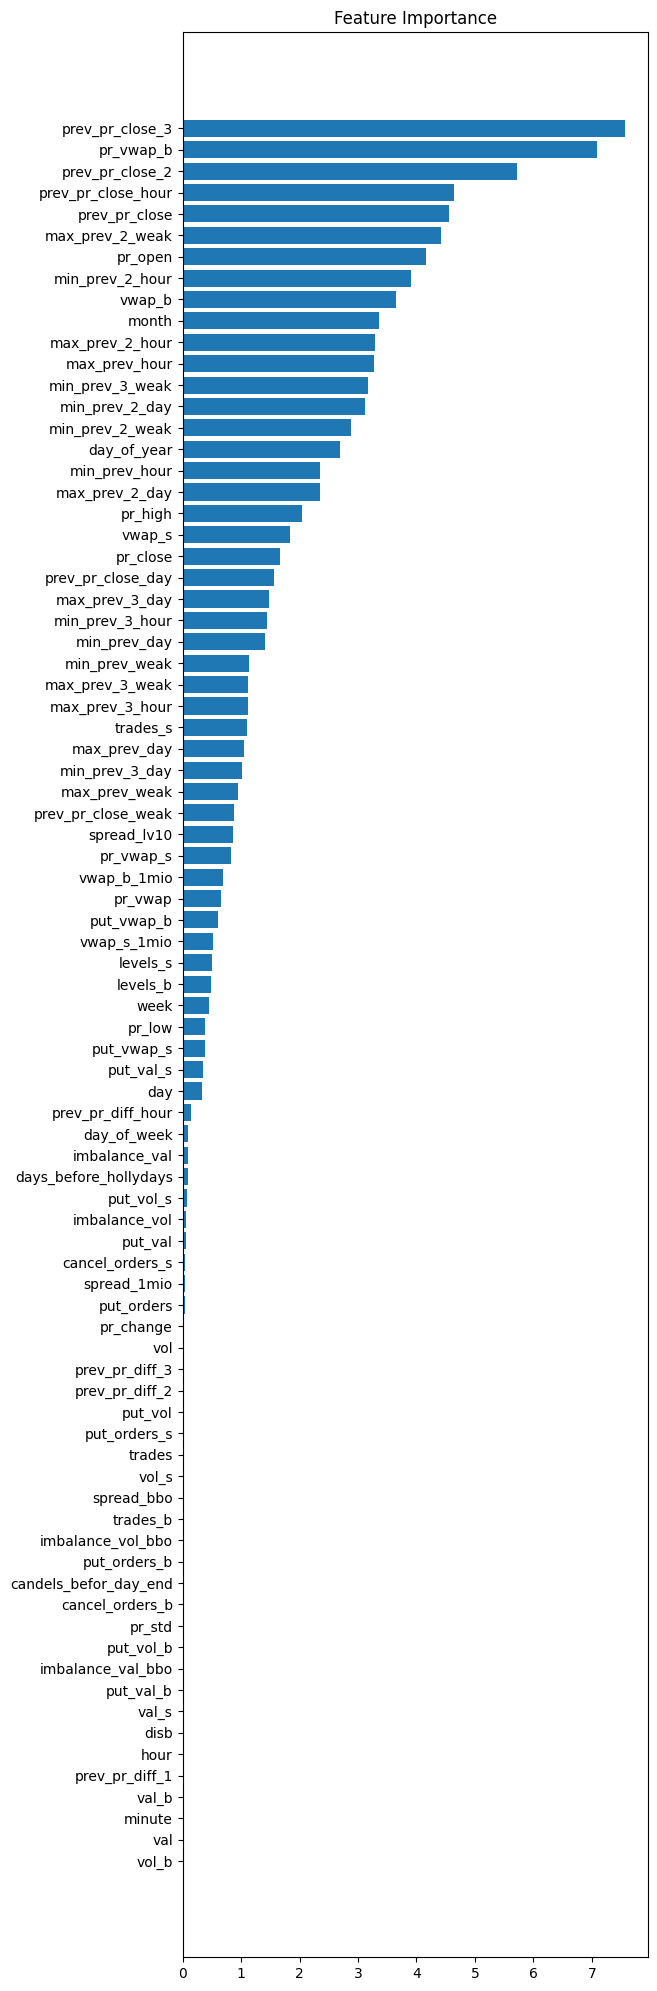

In [148]:
feature_importance = cbr.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(6, 25))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

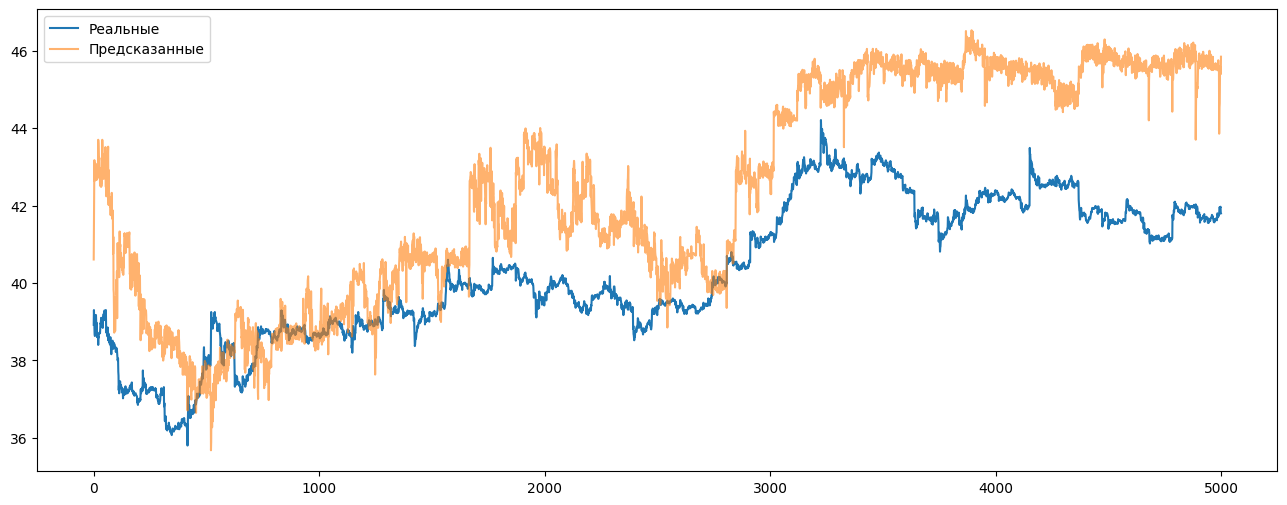

In [149]:
values_to_plot = 5000
ind = 0

cur_col = ['target_hour', 'target_day', 'target_weak'][ind]

fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(np.array(y_test)[:values_to_plot])
ax.plot(pred_cbr[:values_to_plot], alpha=0.6)
ax.legend(['Реальные', 'Предсказанные'])
plt.show()

# Финальное обучение

In [129]:
import pickle as pkl
import json

In [175]:
for stock in stocks:
    df = df_copy[df_copy.secid == stock]
    df.reset_index(drop=True, inplace=True)
    
    df = add_features(df)
    
    y, X = add_target_and_split_y_X(df, 12)
    name_for = ['hourly', 'daily', 'weekly'][0]
    
    cbr = CatBoostRegressor(random_state=42, loss_function='MAE', verbose=False)
    cbr.fit(X, y)
    
    with open(f"models/{name_for}_models/model_{stock}.pkl" , 'wb') as file: 
        pkl.dump(cbr, file)
    
    with open(f'models/{name_for}_models/features_{stock}.json', 'w') as file:
        json.dump(list(X.columns), file)
    
    del cbr
    del df

In [131]:
def add_features(df):
    # минимумы и макимумы в прошлые 1, 2, 3 - час, день, неделю, (месяц)
    # минимумы и макимумы за прошлый час 
    df['max_prev_hour'] = df['pr_close'].rolling(window=12+1).max()
    df['min_prev_hour'] = df['pr_close'].rolling(window=12+1).min()
    
    # минимумы и макимумы за прошлый день 
    df['max_prev_day'] = df['pr_close'].rolling(window=104+1).max()
    df['min_prev_day'] = df['pr_close'].rolling(window=104+1).min()
    
    # минимумы и макимумы за прошлую неделю 
    df['max_prev_weak'] = df['pr_close'].rolling(window=104*5+1).max()
    df['min_prev_weak'] = df['pr_close'].rolling(window=104*5+1).min()
    
    # минимумы и макимумы за второй прошлый час
    df['max_prev_2_hour'] = df['pr_close'].rolling(window=12*2+1).max()
    df['min_prev_2_hour'] = df['pr_close'].rolling(window=12*2+1).min()
    
    # минимумы и макимумы за второй прошлый день 
    df['max_prev_2_day'] = df['pr_close'].rolling(window=104*2+1).max()
    df['min_prev_2_day'] = df['pr_close'].rolling(window=104*2+1).min()
    
    # минимумы и макимумы за вторую прошлую неделию
    df['max_prev_2_weak'] = df['pr_close'].rolling(window=104*5*2+1).max() 
    df['min_prev_2_weak'] = df['pr_close'].rolling(window=104*5*2+1).min()  
    
    # минимумы и макимумы за третий прошлый час
    df['max_prev_3_hour'] = df['pr_close'].rolling(window=12*3+1).max() 
    df['min_prev_3_hour'] = df['pr_close'].rolling(window=12*3+1).min()
    
    # минимумы и макимумы за третий прошлый день 
    df['max_prev_3_day'] = df['pr_close'].rolling(window=104*3+1).max()
    df['min_prev_3_day'] = df['pr_close'].rolling(window=104*3+1).min()
    
    # минимумы и макимумы за третию прошлую неделию
    df['max_prev_3_weak'] = df['pr_close'].rolling(window=104*5*31).max()
    df['min_prev_3_weak'] = df['pr_close'].rolling(window=104*5*31).min()

    # предыдущие цена закрытия за час, день, неделю, (месяц)
    df['prev_pr_close'] = df.pr_close.shift(1)
    df['prev_pr_close_2'] = df.pr_close.shift(2)
    df['prev_pr_close_3'] = df.pr_close.shift(3)
    df['prev_pr_close_hour'] = df.pr_close.shift(12)
    df['prev_pr_close_hour'] = df.pr_close.shift(12*2)
    df['prev_pr_close_hour'] = df.pr_close.shift(12*3)
    df['prev_pr_close_day'] = df.pr_close.shift(104)
    df['prev_pr_close_weak'] = df.pr_close.shift(104*5)
    
    # разность между ценой открытия и закрытия за прошлый час, день, месяц
    df['prev_pr_diff_hour'] = df.pr_close.shift(1) - df.pr_open.shift(12)
    df['prev_pr_diff_1'] = df.pr_close.shift(1) - df.pr_open.shift(1)
    df['prev_pr_diff_2'] = df.pr_close.shift(1) - df.pr_open.shift(2)
    df['prev_pr_diff_3'] = df.pr_close.shift(1) - df.pr_open.shift(3)

    # временные признаки
    # дней до выходных
    # 5 минутных свечей до закрытия торгов
    df["day_of_week"] = df['tradedate'].apply(lambda x: x.weekday())
    df["day_of_year"] = df['tradedate'].apply(lambda x: x.timetuple().tm_yday)
    df["month"] = df['tradedate'].apply(lambda x: x.month)
    df["week"] = df['tradedate'].apply(lambda x: x.isocalendar().week)
    df["day"] = df['tradedate'].apply(lambda x: x.day)
    df["hour"] = df['tradetime'].apply(lambda x: x.hour)
    df["minute"] = df['tradetime'].apply(lambda x: x.minute)
    
    df['candels_befor_day_end'] =  104 - ((df['hour'] - 10) * 12 + (df['minute']/ 5))   
    df['days_before_hollydays'] =  5 - df['day_of_week']

    df.fillna(-1, inplace=True)

    to_drop = ['cancel_val_b', 'cancel_val_s', 'cancel_vol_b', 'cancel_vol_s', 'cancel_vwap_b', 'cancel_vwap_s', 
           'cancel_vol', 'cancel_val', 'cancel_orders', 'secid']
    df.drop(columns=to_drop, inplace=True)
    
    return df

In [155]:
def add_target_and_split_y_X(df, period):
    df['target'] = df.pr_close.shift(-period)

    df = df[104*5*3:len(df)-period]
    
    train = df.drop(columns=['tradedate', 'tradetime'])
    X = train.drop(columns=['target'])
    y = train['target']
    
    return y, X